In [2]:
import sys
sys.path.insert(0, "../spectral_approximate_inference")
sys.path.insert(0, "../")
import numpy as np
import matplotlib.pyplot as plt
from read_mat import ReadMat
import pandas as pd
import time
import scipy.io as sio
import math
import sdp_mrf
from sdp_mrf.models import PottsModel

In [3]:
sys.path.insert(0, "../spectral_approximate_inference/gm")
sys.path.insert(0, "../spectral_approximate_inference/inference")
from gm import *
from factor import *
from ising_model import *
from rank1_ising import Rank1Ising
import scipy.io as sio

<h2> Geometric method by Wang et al. ICLR 2014

In [4]:
def compute_logZ_sdp_iclr(A, h, rounding_iters=10000):
    # Convert vector to string
    def get_string_from_vector(v):
        ret = ""
        for digit in v:
            if digit == -1:
                ret += "0"
            else:
                ret += "1"
        return ret
    
    # Sample n vectors uniformly on unit sphere
    def sample_unit_sphere(d, n):
        ret = np.random.normal(0, 1, size=(d, n))
        ret = ret / np.linalg.norm(ret, axis=0, keepdims=True)
        return ret

    def get_angle(cos_theta):
        assert -1 <= cos_theta
        assert cos_theta <= 1
        return math.acos(cos_theta)
    
    def get_perp_vector(v):
        return np.array((-v[1], v[0]))
    
    # Run the mixing method for optimization
    def mixing_method(V, A, h, max_iters=100):
        n = len(A)
        d = V.shape[0]
        for _ in range(max_iters):
            for i in range(n):
                accumulation = np.zeros(d)
                accumulation[0] = h[i]
                for j in range(n):
                    accumulation = accumulation + A[i, j] * V[:, j]
                accumulation = accumulation / np.linalg.norm(accumulation)
                V[:, i] = accumulation
        return V
    
    n = len(A)
    d = 2
    V = sample_unit_sphere(d, n)
    
    # Setting v_t = e_d
    v_t = np.zeros(d)
    v_t[-1] = 1
    
    # Perform mixing method on V
    V = mixing_method(V, A, h)
    
    sdp_logZ = np.trace(A.T @ (V.T @ V)) / 2 + (h.T @ (V.T @ v_t)) # <A, V^TV> / 2 + <h, V^Tv_t>
    
    angles_list = [0, np.pi]
    for i in range(V.shape[1]):
        perp_vec = get_perp_vector(V[:, i])
        if perp_vec[1] < 0:
            perp_vec = -perp_vec
        cos_theta = perp_vec.T @ np.array((1, 0))
        angles_list.append(get_angle(cos_theta))
    
    angles_list = sorted(angles_list)
    
    p_v = {}
    for i in range(len(angles_list) - 1):
        angle = (angles_list[i] + angles_list[i+1]) / 2
        r = np.array((np.cos(angle), np.sin(angle)))
        rounded_v = np.array([np.sign((V[:, j].T @ r) * (v_t.T @ r)) for j in range(n)])
        s = get_string_from_vector(rounded_v)
        p_v[s] = (angles_list[i+1] - angles_list[i]) / np.pi # pi coz have to multiply prob by 2
    
    f_list = []
    mx = -np.inf
    for _ in range(rounding_iters):
        r = sample_unit_sphere(d, 1)
        r = np.reshape(r, -1)
        x = np.array([np.sign((V[:, j].T @ r) * (v_t.T @ r)) for j in range(n)])
        f = (x.T @ A @ x) / 2 + (h.T @ x)
        s = get_string_from_vector(x)
        assert s in p_v
        f_list.append(f - np.log(p_v[s]))
        mx = max(mx, f - np.log(p_v[s]))
    
    f_list = np.array(f_list)
    f_list = f_list - mx
    rounded_logZ = np.log(np.sum(np.exp(f_list)))
    rounded_logZ += mx
    rounded_logZ -= np.log(rounding_iters)
 
    return sdp_logZ, rounded_logZ

<h2> Binary ER graphs

In [5]:
mat = sio.loadmat('../data/ER_5_data.mat')
coupling_data = mat['coupling']
bias_data = mat['bias']
logZ_data = mat['logZ']
print(coupling_data.shape, bias_data.shape, logZ_data.shape)
n = coupling_data.shape[0]
cw_len = coupling_data.shape[-2]
num_samples = coupling_data.shape[-1]

# Required to run Park et al; refer to spectral_approximate_inference/matlab_code/check.m
# on how to compute these matrices
US_mat = sio.loadmat('../data/ER_correct_5_Ux_Sx.mat')
Ux = US_mat["Ux"]
Sx = US_mat["Sx"]
print(Ux.shape, Sx.shape)

(20, 20, 21, 100) (20, 21, 100) (21, 100)
(21, 21, 21, 100) (21, 21, 21, 100)


In [8]:
# Run Spectral AI (Park et al.) on all the problem instances
rank1_error = []
time_rank1_list = []
for cw in range(cw_len):
    diff_rank1 = []
    for sample in range(num_samples):
        print("CW =", cw, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, cw, sample]
        h = bias_data[:, cw, sample]
        ground_truth = logZ_data[cw, sample]
        im = IsingModel(h, A)
        
        V, s = Ux[:, :, cw, sample], np.diag(Sx[:, :, cw, sample])
        st = time.time()
        rank = Rank1Ising(im, V, s)
        diff_rank1.append(np.abs(ground_truth - rank.run_rank1()))
        time_rank1_list.append(time.time() - st)
    rank1_error.append(np.mean(diff_rank1))
    
# Run our algorithm on all the problem instances
sdp_r = []
t_list = []
rounding_iters = 500
model = PottsModel()
for i in range(cw_len):
    diff_sdp_r = []
    for sample in range(num_samples):
        print("CW =", i, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, i, sample]
        h = np.zeros((n, 2))
        h[:, 0] = bias_data[:, i, sample]
        ground_truth = logZ_data[i, sample]
        model.set_model_parameters(A, h, 2)
        s = time.time()
        rounded_logZ = model.solve_partition_function(solver='M4', rounding_iters=rounding_iters)
        t_list.append(time.time() - s)
        diff_sdp_r.append(np.abs(ground_truth - rounded_logZ))
    sdp_r.append(np.mean(diff_sdp_r))

# Run the method by Wang et al. on all the problem instances
sdp_iclr_error = []
time_sdp_iclr_list = []
for i in range(cw_len):
    diff_sdp_iclr = []
    for sample in range(num_samples):
        print("CW =", i, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, i, sample]
        h = bias_data[:, i, sample]
        ground_truth = logZ_data[i, sample]
        s = time.time()
        _, sdp_iclr_estimate = compute_logZ_sdp_iclr(A, h, rounding_iters=500)
        time_sdp_iclr_list.append(time.time() - s)
        diff_sdp_iclr.append(np.abs(ground_truth - sdp_iclr_estimate))
    sdp_iclr_error.append(np.mean(diff_sdp_iclr))

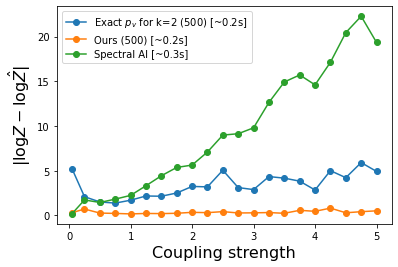

In [9]:
x_axis = np.arange(0, 5.25, 0.25)
x_axis[0] = 0.05

plt.plot(x_axis, sdp_iclr_error, marker="o", label="Exact $p_v$ for k=2 (500) [~0.2s]")
plt.plot(x_axis, sdp_r, marker="o", label="Ours (500) [~0.2s]")
plt.plot(x_axis, rank1_error, marker="o", label="Spectral AI [~0.3s]")
plt.xticks([0, 1, 2, 3, 4, 5], rotation="horizontal")
plt.legend(loc="upper left")
# plt.xticks(cw_range, rotation="vertical")
plt.xlabel("Coupling strength", fontsize=16)
plt.ylabel("$|\log Z - \log \hat{Z}$|", fontsize=16)
plt.show()